In [1]:
%matplotlib inline
# IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# KDE stuff
# from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import LeaveOneOut

# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

# import eli5
# from eli5.sklearn import PermutationImportance

# import graphviz
# from sklearn import tree
from sklearn.inspection import PartialDependenceDisplay

First we import the shot data for the 2022-23 NHL season. The data is from moneypuck.com. Each row corresponds to one shot taken during the season, so all shots are included. The dataframe has been modified to include the defending team, and "real game ID". All of the column names can be printed along with their first value to get an idea of what the data looks like. All rows corresponding to playoff games and shots against empty nets are removed.

In [2]:
# DATA

fn = '/Users/akshayghosh/hockey/hockey_kde/data/shots_2022_modified.csv'

df = pd.read_csv(fn)
df.describe()
  
# for col in df.keys():print('{:<50}  {:>50}'.format(col , df[col][0]))
    
df = df[df['isPlayoffGame'] == 0] # select only regular season
df = df[df['shotOnEmptyNet'] == 0] # discard shots on empty nets

The target variable to predict (aka the label) is xGoal, which is the probability of that shot resulting in a goal by MoneyPuck. Right now the features are very simple, just the distance and absolute value of the shot angle. My initial goal was to make my model as simple as possible, and possibly add more features later. I believe that the most important factors in the quality of a shot are the distance and angle, where closer and towards the middle is the ideal shot location.

The MoneyPuck model is explained here: https://moneypuck.com/about.htm#shotModel
And is as follows (from their website):

Shot Prediction Expected Goals Model

"This model predicts the probability of each shot being a goal. Factors such as the distance from the net, angle of the shot, type of shot, and what happened before the shot are key factors in the model. This model was built on over 50,000 goals and 800,000 shots in NHL regular season and playoff games from the 2007-2008 to 2014-2015 season with location data. By adding up all the probabilities of a team's shots during a game, we can calculate the team's expected goals in that game. The model was built using gradient boosting. MoneyPuck's expected goals model uses a different variable strategy than other expected goals like from Corsica Hockey or HockeyGraphs.com. The MoneyPuck expected goals model does not explicitly use variables for rebounds or rush shots. Rather, it looks at the 'speed' between events: The distance on the ice between the shot and the event before it divided by the amount of time that's elapsed. Also, for rebound shots the model looks at the change in angle between the shots divided by the amount of time between the two shots. The illustrations below describe how the speed variables are created."

In [3]:
'''
set up features and labels

want to predict: xGoal
features to use: []
'''

y = df.xGoal

features = ['shotDistance','shotAngleAdjusted']
X = df[features]

# split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

This is where we set up the model, using a gradient boost. You can also see the Random Forest Regressor which I previously used. The mean absolute error is printed. The predictions of goal probability are applied to all rows, to compare against the moneypuck probabilities.

In [4]:
# PREDICT XGOAL

# forest_model = RandomForestRegressor(random_state = 1)# define model

forest_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

forest_model.fit(X_train, y_train) # fit with training data
# forest_model.fit(X, y) # fit with training data
# pred_xgoal = forest_model.predict(X_val) # make prediction with val data
pred_xgoal = forest_model.predict(X) # make prediction with ALL data

MAE = mean_absolute_error(pred_xgoal, y)
print(f'MAE = {round(MAE,4)}')

# print(np.shape(pred_xgoal))
# print(np.shape(y))

MAE = 0.0322


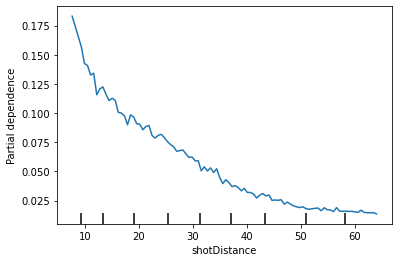

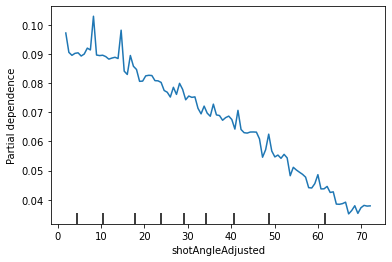

In [5]:
for feat_name in features:
    PartialDependenceDisplay.from_estimator(forest_model, X_val, [feat_name])
    plt.show()

Here, we look at the partial dependence of the two features, which tells us the effect of the features on the predicted outcome of the model (probability of a goal). We can see that as the shot is from further away, this probability decreases. Also, as the shot is further from the center and more towards the boards, this also decreases the probability. According to this model, the ideal shot location is from close and center to the net which is exactly what we expect from extremely conventional hockey knowledge.

This is looking at the total "expected goals" according to the money puck data. This is done by summing the probability of xGoal for every shot.

In [6]:
'''
use col 'shooterName' to find who had highest xGoal last year (to compare my model against)
'''

# group by 'shooterName' and sum up 'xGoal' values
grouped = df.groupby('shooterName')['xGoal'].sum()

# sort the grouped series in descending order
sorted_grouped = grouped.sort_values(ascending=False)

# print out the top 30 shooterName values and their cumulative xGoal
top_30 = sorted_grouped.head(20)

print('PLAYER                              xGOALS (MP)')
print('-------------------------------------------------')
for shooter, xGoal in top_30.items():
    print('{:<25}  {:>15}'.format(shooter, round(xGoal,3)))

PLAYER                              xGOALS (MP)
-------------------------------------------------
Zach Hyman                          47.899
Brady Tkachuk                       44.993
John Tavares                        43.993
Matthew Tkachuk                     43.512
Connor McDavid                      41.553
David Pastrnak                      39.592
Timo Meier                          38.239
Brayden Point                       38.149
Auston Matthews                     37.683
Anders Lee                          35.443
Sebastian Aho                       34.369
Chris Kreider                       34.355
Tage Thompson                       34.331
Leon Draisaitl                      33.893
Nico Hischier                       33.436
Kirill Kaprizov                     33.361
Jake Guentzel                       33.333
Drake Batherson                     33.205
Mikko Rantanen                      32.651
Rickard Rakell                      32.459


It is interesting that Zach Hyman and Brady Tkachuk lead in expected goals, outperforming noted exceptional goal scorers such as McDavid, Pastrnak, Matthews, Ovechkin, and Draisaitl. Brady and Hyman both play similar styles where they like to stay around close to the net and jam at pucks. This could result in a higher expected goals than actual goals.

In [7]:
grouped = df.groupby('shooterName').agg({'xGoal': 'sum', 'goal': 'sum', 'shotGeneratedRebound': 'sum' , 'shooterName': 'count'})
grouped['goal_residual'] = grouped['goal'] - grouped['xGoal'] # add new col that is total goals - xgoals

# plt.figure(dpi = 150)
# plt.title('MP Model')
# plt.xlabel('Goals - xGoals')
# plt.hist(grouped.goal_residual,bins = 80,edgecolor='black')
# plt.show()


# print biggest discrepencies between goals and xgoals
sorted_grouped = grouped.sort_values(by='goal_residual', ascending=True)

# print out the top 30 shooterName values, their cumulative xGoal, and sum of 'goal'
print('shooterName             MP: cumulative xGoal    Goals - xGoals')
print('------------------------------------------------------------')
for index, row in sorted_grouped.head(20).iterrows():
    print('{:<25}  {:>15}  {:>15}'.format(index, round(row['xGoal'],3), round(row['goal_residual'],3)))
    
print()
    
print('shooterName             MP: cumulative xGoal    Goals - xGoals')
print('------------------------------------------------------------')
for index, row in sorted_grouped.tail(20)[::-1].iterrows():
    print('{:<25}  {:>15}  {:>15}'.format(index, round(row['xGoal'],3), round(row['goal_residual'],3)))

shooterName             MP: cumulative xGoal    Goals - xGoals
------------------------------------------------------------
Zach Hyman                          47.899          -16.899
Seth Jarvis                         25.209          -11.209
Drake Batherson                     33.205          -11.205
Brady Tkachuk                       44.993          -10.993
Blake Coleman                       24.465          -10.465
Joel Eriksson Ek                     30.41            -9.41
Tanner Jeannot                      14.383           -9.383
Stefan Noesen                       21.372           -9.372
John Tavares                        43.993           -8.993
Michael Eyssimont                   13.366           -8.366
Mikael Granlund                     16.092           -8.092
Cole Sillinger                      11.062           -8.062
Zach Parise                         25.035           -8.035
Quinton Byfield                     10.029           -8.029
William Karlsson                    

Here we see the largest discrepancies between expected and actual goals, both ways. Different discrepancies could be for different reasons. I will comment on the 2 Sens players in the top 4. I am just guessing, but I think Brady Tkachuk plays a game style that will naturally result in a very high expected number of goals. Whereas Batherson did seem to be rather "snake-bitten" or "unlucky" this season.

In [8]:
'''
add the calculated xgoal to the dataframe and compare
'''

df['pred_xgoal'] = pred_xgoal

# for col in df.keys():print('{:<50}  {:>50}'.format(col , df[col][0]))

grouped_pred = df.groupby('shooterName').agg({'xGoal': 'sum', 'goal': 'sum', 'pred_xgoal': 'sum'})
grouped_pred['goal_residual'] = grouped_pred['goal'] - grouped_pred['xGoal']
grouped_pred['pred_goal_residual'] = grouped_pred['goal'] - grouped_pred['pred_xgoal'] # add new col that is total goals - xgoals
grouped_pred['residual_difference'] = grouped_pred['pred_goal_residual'] - grouped_pred['goal_residual']    
    
# print biggest discrepencies between goals and xgoals
sorted_grouped_pred = grouped_pred.sort_values(by='pred_goal_residual', ascending=True)

# print out the top 30 shooterName values, their cumulative xGoal, and sum of 'goal'
print('shooterName             AG: cumulative xGoal    Goals - xGoals')
print('------------------------------------------------------------')
for index, row in sorted_grouped_pred.head(20).iterrows():
    print('{:<25}  {:>15}  {:>15}'.format(index, round(row['pred_xgoal'],3), round(row['pred_goal_residual'],3)))
    
print()
    
print('shooterName             AG: cumulative xGoal    Goals - xGoals')
print('------------------------------------------------------------')
for index, row in sorted_grouped_pred.tail(20)[::-1].iterrows():
    print('{:<25}  {:>15}  {:>15}'.format(index, round(row['pred_xgoal'],3), round(row['pred_goal_residual'],3)))

shooterName             AG: cumulative xGoal    Goals - xGoals
------------------------------------------------------------
Zach Hyman                          46.991          -15.991
Brady Tkachuk                       47.943          -13.943
Seth Jarvis                         26.216          -12.216
Vincent Trocheck                    32.076          -12.076
Stefan Noesen                       23.472          -11.472
Joel Eriksson Ek                    32.285          -11.285
Blake Coleman                       25.069          -11.069
John Tavares                        46.006          -11.006
Michael Eyssimont                   15.059          -10.059
Bryan Rust                          28.057          -10.057
Tanner Jeannot                      14.799           -9.799
Jordan Martinook                    20.532           -9.532
William Karlsson                    21.232           -9.232
Quinton Byfield                     11.193           -9.193
Zach Parise                         

Now for the results of my model using just shot distance and (the absolute value of) shot angle. Hyman and Brady Tkachuk still have their expected goals overestimated. Draisaitl, Pastrnak, and Mcdavid still have their expected goals underestimated. Overall, my model performs similarly to the MoneyPuck model for this dataset, but is much more simple. Jared McCann is a player that stands out with 22 more goals scored than expected, and is among superstar players.

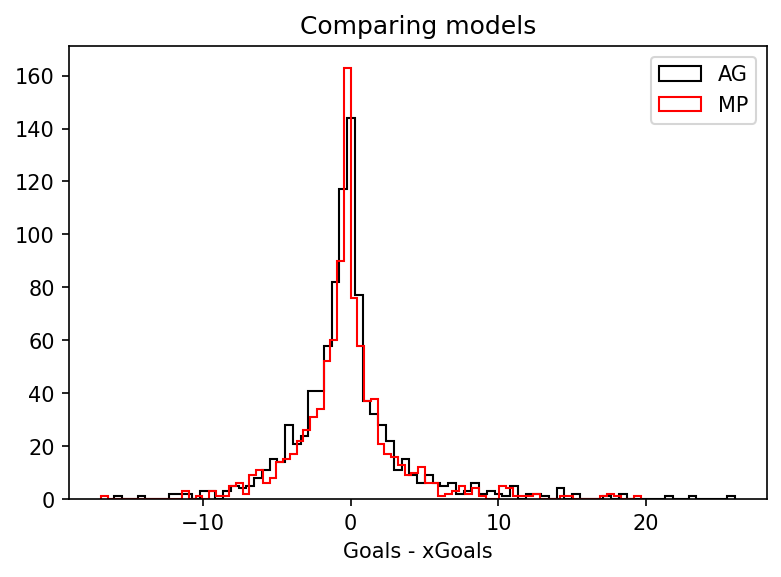

In [9]:
plt.figure(dpi = 150)
plt.title('Comparing models')
plt.xlabel('Goals - xGoals')
plt.hist(sorted_grouped_pred.pred_goal_residual,bins = 80,edgecolor='black',histtype = 'step',label = 'AG')
plt.hist(grouped.goal_residual,bins = 80,edgecolor='red',histtype = 'step',label = 'MP')
plt.legend()
plt.show()

Here we compare the spread of the discrepancies between goals and expected goals, of my model (black line), versus the MoneyPuck model (red line). We can see that the distributions are similar.

In [10]:
stats_mp = stats.describe(sorted_grouped_pred['goal_residual'])
stats_ag = stats.describe(sorted_grouped_pred['pred_goal_residual'])

print(stats_mp)
print(stats_ag)
print()
print('STATS:')
print('          MP          AG')
print('Mean:  ',round(np.mean(sorted_grouped_pred['goal_residual']),5),round(np.mean(sorted_grouped_pred['pred_goal_residual']),5))
print('Stddev: ',round(np.std(sorted_grouped_pred['goal_residual'],ddof = 1),5),round(np.std(sorted_grouped_pred['pred_goal_residual'],ddof = 1),5))

DescribeResult(nobs=939, minmax=(-16.899072269999998, 19.63611216), mean=-0.21026038839190622, variance=12.27154132784601, skewness=1.058824031052149, kurtosis=5.869089488295035)
DescribeResult(nobs=939, minmax=(-15.99087905883789, 26.017427444458008), mean=-0.20029445838369628, variance=15.624969102126347, skewness=1.4153605216139018, kurtosis=7.33646425953107)

STATS:
          MP          AG
Mean:   -0.21026 -0.20029
Stddev:  3.50308 3.95284


## FINAL NOTES

Overall, my model and the MoneyPuck model perform similarly.

What I find interesting is that it seems that the better players tend to have less expected goals versus actual goals, with that list including Leon Draisaitl, David Pastrnak, Connor McDavid , Mikko Rantanen, and Tage Thompson as the leaders, all of which who are superstars. Jared McCann is also in that list, and personally I would not include him as a superstar so it is interesting that he scored 22 goals more than expected. We did not gain much new information from this analysis, other than potentially making predictions about the outlier players (such as McCann). This does involve prior knowledge about these players.


After this analysis, I have two predictions for the 2023-24 season:

1. Seth Jarvis will see an increase in goal production, and score 30 or more goals.
2. Jared McCann will regress and score 20 or less goals.